## EX_09  폐렴 진단기 만든 후 성능 높이기👩‍⚕

### 목표: 폐렴 진단기 성능을 높여라

#### lubric

1. 의료영상을 처리하는 CNN 기반 딥러닝 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. 데이터 준비, 모델구성, regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 Accuracy 기준 85%에 도달하였다.

* ablation study 는 모델이나 알고리즘의 "feature" 들을 제거하면서 그게 성능에 어떤 영향을 줄지 연구하는 것

#### 🚩keyword

✔ CNN
http://taewan.kim/post/cnn/

#### 1. Set-up

In [29]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [30]:
# 앞으로 필요한 변수들을 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/EXPLORATIONS/EX_09')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel/EXPLORATIONS/EX_09


#### 2. 데이터 가져오기

In [31]:
# 각 데이터들의 개수를 한번 체크

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [32]:
#  val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져오기
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [33]:
# 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/EXPLORATIONS/EX_09/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/EXPLORATIONS/EX_09/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [34]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


유용한 작업을 위해 tf.data 인스턴스를 만들기
tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 준다.

- what is minibatch?https://acdongpgm.tistory.com/202

In [35]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [36]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [37]:
# 현재 이미지에는 라벨 데이터가 따로 없다.
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들기
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [38]:
# 이미지 사이즈를 줄이기
# process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경.
# get_label을 이용해서 라벨 값을 가져옵니다

# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [39]:
# train 데이터 셋과 validation 데이터 셋을 만들기 
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있다.

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [40]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [41]:
# test 데이터셋도 만들기. 그리고 데이터 개수도 확인

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


__<Tensorflow에서 tf.data 파이프라인>__
<br>
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택.

- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [42]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### 3. 데이터 시각화

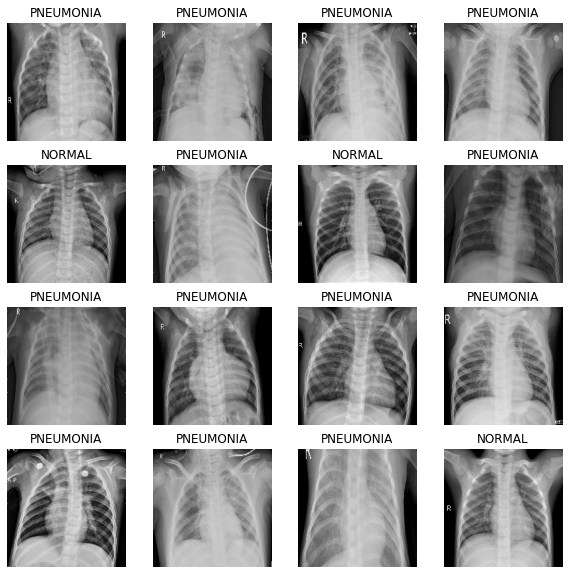

In [43]:
#  train에 있는 batch 중 첫 번째 배치를 추출
# 추출된 배치를 image와 label 데이터 셋으로 나누고 show_batch() 함수를 이용해서 결과 사진 확인

# 이미지 배치를 입력하면 여러장의 이미지를 보여준다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

#### 4. CNN 모델링

In [44]:
# 먼저, Convolution block을 만들고
# conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결. 
# 그리고 Max Pooling 진행.

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [45]:
# Dense Block은 아래와 같이 만들고

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

참고) 우리가 만들 CNN 모델은 약간의 수정을 거쳐 전형적인 CNN 모델과는 약간 다른 모델입니다.
방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다.그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 있습니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있기 때문입니다.

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

In [46]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 5. 데이터 imbalance 처리

__우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 한다.__

__Weight balancing: Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원__

In [47]:
# 아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅. 
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정.

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


#### 6. 모델 훈련

In [48]:
# 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언.
# 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용. optimizer로 'adam'을 사용.
# 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용.

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [49]:
# 모델 fit 진행. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어준다. 
# 모델 학습시 약 20분 이상 소요

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 192ms/step - loss: 0.3763 - accuracy: 0.8381 - precision: 0.9598 - recall: 0.8164 - val_loss: 0.6672 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2277 - accuracy: 0.9076 - precision: 0.9749 - recall: 0.8989 - val_loss: 1.3186 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1924 - accuracy: 0.9308 - precision: 0.9780 - recall: 0.9280 - val_loss: 0.4581 - val_accuracy: 0.8394 - val_precision: 0.8208 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1806 - accuracy: 0.9320 - precision: 0.9770 - recall: 0.9304 - val_loss: 0.3011 - val_accuracy: 0.9087 - val_precision: 1.0000 - val_recall: 0.8758
Epoch 5/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1594 - accura

#### 7. 결과 확인

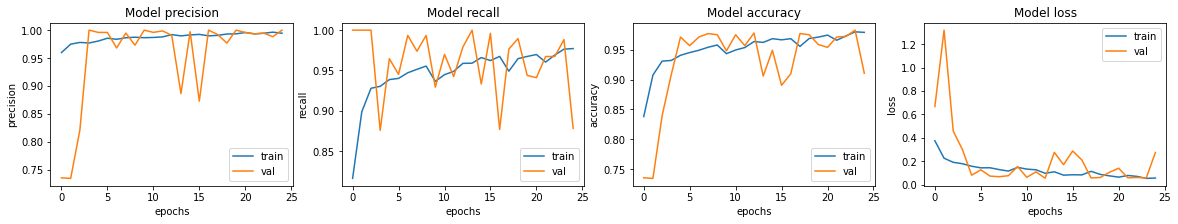

In [50]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여준다

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
# 테스트 데이터로 모델 평가 진행
# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 0.4876 - accuracy: 0.8766 - precision: 0.8883 - recall: 0.9179
Loss: 0.48762160539627075,
Accuracy: 0.8766025900840759,
Precision: 0.8883374929428101,
Recall: 0.9179487228393555


__모델을 세 번 학습 시켰는데 세번 다 다른 accuracy를 얻었다. 마지막 시도에선 87%라니!__

#### 프로젝트 : 폐렴 진단기 성능개선

1. Step 1. 실험환경 Set-up
2. Step 2. 데이터 준비하기
3. Step 3. 데이터 시각화
4. Step 4. CNN 모델링
5. Step 5. 데이터 imbalance 처리
6. Step 6. 모델 훈련
7. Step 7. 결과 확인과 시각화

### trial and error

CNN 모델은 CV에서도 가장 중요한 모델이며 알아야할 모델이지만 NLP에 빠져있는 요즘 또 다음 과제가 GAN과 시계열 분석이라 루브릭1만 만족하고 넘어가는 수준으로 진행했다. 막히는 부분은 없었으며 모델 학습 횟수에 따라 정확도가 달라졌는데 이부분은 항상 궁금할 따름. 나중에 여유가 생기면 꼭 다시 짚고 넘어가고 싶은 노드로 막을 내리는 걸로 :D